In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import scipy.optimize as opt

In [2]:
t0 = 0
#ntrials = 3
gamma = 10
halfstep = 0.05
factor = 1
eta = 10

In [3]:
def gillespie_step(x,a0,v):
    xocc = np.array([x[0],x[1],x[1],x[2],x[2],\
                     x[0],x[3],x[3],x[4],x[4],\
                    x[0],x[5],x[5],x[6],x[6],\
                    x[0],x[7],x[7],x[8],x[8]])
    #xocc[xocc != 0] = 1
    a = a0*xocc

    at = np.sum(a)

    r1 = np.random.rand()
    r2 = np.random.rand()

    tau = 1/at*np.log(1/r1)

    numel = np.size(a)
    thresh = at*r2
    for ii in range(numel):
        jj = ii + 1
        aj = np.sum(a[:jj])
        if aj < thresh:
            continue
        else:
            j = ii
            dx = v[j,:]
            break
    
    dt = tau
    return dx,dt,j

In [4]:
"""
define rate constants and the topology of the model; 4 state
"""
a01 = 3e0
a10 = 1e0
a12 = 5e3
a21 = 1e3
a20 = 7e0 #this is the base rate, we will alter this as a function of ATP later
"""
"""
#the order of reactions in the following 
#[[01],[10],[12],[21],[20],\ [03],[30],[34],[43],[40]]

v = np.array([[-1,1,0,0,0,0,0,0,0],[1,-1,0,0,0,0,0,0,0],[0,-1,1,0,0,0,0,0,0],[0,1,-1,0,0,0,0,0,0],[1,0,-1,0,0,0,0,0,0],\
              [-1,0,0,1,0,0,0,0,0],[1,0,0,-1,0,0,0,0,0],[0,0,0,-1,1,0,0,0,0],[0,0,0,1,-1,0,0,0,0],[1,0,0,0,-1,0,0,0,0],\
              [-1,0,0,0,0,1,0,0,0],[1,0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,1,0,0],[0,0,0,0,0,1,-1,0,0],[1,0,0,0,0,0,-1,0,0],\
             [-1,0,0,0,0,0,0,1,0],[1,0,0,0,0,0,0,-1,0],[0,0,0,0,0,0,0,-1,1],[0,0,0,0,0,0,0,1,-1],[1,0,0,0,0,0,0,0,-1]])

a0 = np.array([a01,a10,a12,a21,a20,\
               a01,a10,a12,a21,a20,\
               a01,a10,a12,a21,a20,\
               a01,a10,a12,a21,a20])

In [5]:
def is_xlked(tmp_state):
    #the total number of heads bound to filament 1
    fil1 = np.sum(tmp_state[1:5])
    fil2 = np.sum(tmp_state[5:])
    xlked = fil1*fil2
    
    if xlked > 0:
        val = True
    else:
        val = False
    
    return val

In [6]:
n = 8
ATP = 5
K = [5,0.1]
tfinal = 1

count = 0
a00 = np.array([a01,a10,a12,a21,a20*ATP,\
               a01*0,a10,a12,a21,a20*ATP,\
               a01,a10,a12,a21,a20*ATP,\
               a01*0,a10,a12,a21,a20*ATP])
a0 = a00
s0 = [n,0,0,0,0,0,0,0,0]

state = []
time = []
disp = []
pos_x = []
pos_y = []
a_stor = []

t = 0
s = s0
xt = [0,0]

forward = [0,2]

wb11 = []
wb12 = []

wb21 = []
wb22 = []

while t < tfinal:
    
    step = False
    #Gillespie step
    ds,dt,ind = gillespie_step(s,a0,v)

    #update state and time
    s = s + ds
    t = t + dt
    
    #if a head is binding to a filament, add its position to the storage array
    if ind == 0:
        wb11.append(xt[0]+halfstep)
    elif ind == 5:
        wb12.append(xt[0]+halfstep)
    elif ind == 10:
        wb21.append(xt[1]+halfstep)
    elif ind == 15:
        wb22.append(xt[1]+halfstep)
    
    """
    """
    #this is the full monty
    if forward[0] == 0:
        nforw_pps = s[2]
        nbk = s[3] + s[4]
    else:
        nforw_pps = s[4]
        nbk = s[1] + s[2]
    
    if (nbk == 0 and nforw_pps != 0):
        dx = 2*halfstep#*(1 - (K[0]*s[1])/(K[0]*s[1] + K[1]*s[2]))
        xt[0] += dx
        
        #update a0
        a0[forward[0]*5] = 0
        a0[(forward[0]+1)%2*5] = a01
        
        forward[0] = (forward[0]+1)%2
        
        step = True
    """
    """
    if forward[1] == 2:
        nforw_pps = s[6]
        nbk = s[7] + s[8]
    else:
        nforw_pps = s[8]
        nbk = s[5] + s[6]
    
    if (nbk == 0 and nforw_pps != 0):
        dx = 2*halfstep#*(1 - (K[0]*s[1])/(K[0]*s[1] + K[1]*s[2]))
        xt[1] += dx
        
        #update a0
        a0[forward[1]*5] = 0
        a0[(2 + (forward[1]+1)%2)*5] = a01
        
        forward[1] = 2 + (forward[1]+1)%2
        
        step = True
    """
    """
    
    #keep track of displacement events
    if (step and is_xlked(s)):
        disp.append(dx)
        #print('vel = ', np.sum(dx)/dt)
    else:
        disp.append(0)

    
    
    state.append(s)
    time.append(t)
    pos_x.append(xt[0])
    pos_y.append(xt[1])

    count += 1

state = np.asarray(state)
time = np.asarray(time)
disp = np.asarray(disp)
pos_x = np.asarray(pos_x)
pos_y = np.asarray(pos_y)
a_stor = np.asarray(a_stor)

#print(pos_x)


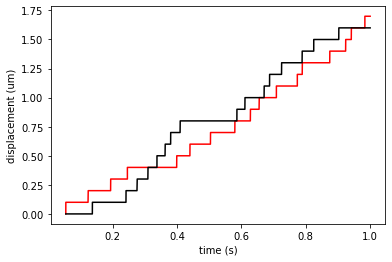

In [7]:
plt.plot(time,pos_x,'r')
plt.plot(time,pos_y,'k')
plt.xlabel('time (s)')
plt.ylabel('displacement (um)')
plt.show()

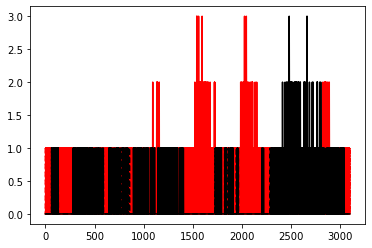

In [8]:
plt.plot(state[:,1],'r--')
plt.plot(state[:,3],'r')
plt.plot(state[:,5],'k--')
plt.plot(state[:,7],'k')
plt.show()

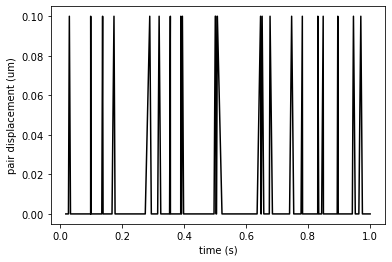

In [11]:
plt.plot(time,disp, 'k')
plt.xlabel('time (s)')
plt.ylabel('pair displacement (um)')
plt.show()